Imports

In [ ]:
import time
import os
import re
import random
import urllib
import urllib.request
import itertools
import bs4
from bs4 import BeautifulSoup
import multiprocessing
from multiprocessing.dummy import Pool
import tensorflow as tf
tf.enable_eager_execution()
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import zipfile

from IPython import display

Define Parameters

In [ ]:
# For loading data
GENRE = "landscape"
BATCH_SIZE = 16
BUFFER_SIZE = 60000
# For defining architecture
NDF = 50  # first layer filter count descriminator
NGF = 150 # first layer filter count generator
NOISE_DIM = 100
# For defining training
EPOCHS = 50*4
LR = 0.0002,            
BETA1 = 0.5,



Mount from drive (optionally)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Move files from drive to working directory

In [ ]:
%%capture
#unzip data
!unzip '/content/drive/My Drive/landscape' -d '/'
#unzip checkpoints
!unzip '/content/drive/My Drive/model_checkpoint' -d '/'


Obtain data from Wikiart.org   [source: ml4a.github.io]

In [ ]:

genre_list = ['portrait', 'landscape', 'genre-painting', 'abstract', 'religious-painting', 
              'cityscape', 'sketch-and-study', 'figurative', 'illustration', 'still-life', 
              'design', 'nude-painting-nu', 'mythological-painting', 'marina', 'animal-painting', 
              'flower-painting', 'self-portrait', 'installation', 'photo', 'allegorical-painting', 
              'history-painting', 'interior', 'literary-painting', 'poster', 'caricature', 
              'battle-painting', 'wildlife-painting', 'cloudscape', 'miniature', 'veduta', 
              'yakusha-e', 'calligraphy', 'graffiti', 'tessellation', 'capriccio', 'advertisement', 
              'bird-and-flower-painting', 'performance', 'bijinga', 'pastorale', 'trompe-loeil', 
              'vanitas', 'shan-shui', 'tapestry', 'mosaic', 'quadratura', 'panorama', 'architecture']

style_list = ['impressionism', 'realism', 'romanticism', 'expressionism', 
            'post-impressionism', 'surrealism', 'art-nouveau', 'baroque', 
            'symbolism', 'abstract-expressionism', 'na-ve-art-primitivism', 
            'neoclassicism', 'cubism', 'rococo', 'northern-renaissance', 
            'pop-art', 'minimalism', 'abstract-art', 'art-informel', 'ukiyo-e', 
            'conceptual-art', 'color-field-painting', 'high-renaissance',
            'mannerism-late-renaissance', 'neo-expressionism', 'early-renaissance', 
            'magic-realism', 'academicism', 'op-art', 'lyrical-abstraction', 
            'contemporary-realism', 'art-deco', 'fauvism', 'concretism', 
            'ink-and-wash-painting', 'post-minimalism', 'social-realism', 
            'hard-edge-painting', 'neo-romanticism', 'tachisme', 'pointillism', 
            'socialist-realism', 'neo-pop-art']

num_downloaded = 0
num_images = 0

def get_painting_list(count, typep, searchword):
    try:
        time.sleep(3.0*random.random())  # random sleep to decrease concurrence of requests
        url = "https://www.wikiart.org/en/paintings-by-%s/%s/%d"%(typep, searchword, count)
        soup = BeautifulSoup(urllib.request.urlopen(url), "lxml")
        regex = r'https?://uploads[0-9]+[^/\s]+/\S+\.jpg'
        url_list = re.findall(regex, str(soup.html()))
        count += len(url_list)
        return url_list
    except Exception as e:
        print('failed to scrape %s'%url, e)


def downloader(link, genre, output_dir):
    global num_downloaded, num_images
    item, file = link
    filepath = file.split('/')
    #savepath = '%s/%s/%d_%s' % (output_dir, genre, item, filepath[-1])
    savepath = '%s/%s/%s' % (output_dir, genre, filepath[-1])    
    try:
        time.sleep(0.2)  # try not to get a 403
        urllib.request.urlretrieve(file, savepath)
        num_downloaded += 1
        if num_downloaded % 100 == 0:
            print('downloaded number %d / %d...' % (num_downloaded, num_images))
    except Exception as e:
        print("failed downloading " + str(file), e) 


def main(typep, searchword, num_pages, output_dir):
    global num_images
    print('gathering links to images... this may take a few minutes')
    threadpool = Pool(multiprocessing.cpu_count()-1)
    numbers = list(range(1, num_pages))
    wikiart_pages = threadpool.starmap(get_painting_list, zip(numbers, itertools.repeat(typep), itertools.repeat(searchword))) 
    threadpool.close()
    threadpool.join()

    pages = [page for page in wikiart_pages if page ]
    items = [item for sublist in pages for item in sublist]
    items = list(set(items))  # get rid of duplicates
    num_images = len(items)
    print("num_images %s"%(num_images))
    
    if not os.path.isdir('%s/%s'%(output_dir, searchword)):
        os.mkdir('%s/%s'%(output_dir, searchword))
    
    print('attempting to download %d images'%num_images)
    threadpool = Pool(multiprocessing.cpu_count()-1)
    threadpool.starmap(downloader, zip(enumerate(items), itertools.repeat(searchword), itertools.repeat(output_dir)))
    threadpool.close    
    threadpool.close()


if __name__ == '__main__':
    typep, searchword = "genre", GENRE
    num_pages = 100
    output_dir = os.path.join(os.getcwd())
    main(typep, searchword, num_pages, output_dir)

Load images

3603
/content/landscape/05-winter-landscape-near-a-village-hendrick-avercamp.jpg


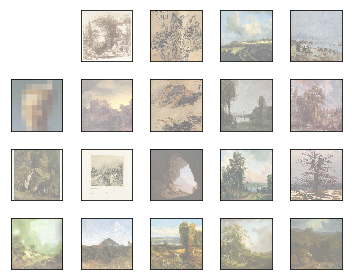

In [ ]:
def load_image(image_path):
    img = tf.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_images(img, (128, 128))
    img = img/255
    return img
  
output_dir = os.path.join(os.getcwd())
path = os.path.join(output_dir, GENRE)
file_list = os.listdir(path)

# getting the unique images
encode_train = sorted(set(file_list))
encode_train = encode_train[:]
encode_train = [os.path.join(path,item) for item in encode_train]
print(len(encode_train))
print(encode_train[0])

# feel free to change the batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(
                                encode_train).shuffle(BUFFER_SIZE).map(load_image).batch(BATCH_SIZE)
image_dataset = image_dataset.apply(tf.data.experimental.ignore_errors()) # skip corrupt jpegs
plt.figure(figsize=(5,4))
i=0
#for i in range(20):
for image in image_dataset:
    i += 1
    #img= load_image(encode_train[i])
    plt.subplot(4,5,i+1)
    plt.imshow((image[0]+1)/2)
    plt.xticks([])
    plt.yticks([])
    if i ==19:
      break
plt.tight_layout()
plt.show()

Augment images

In [ ]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random_uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.0))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(128, 128))
        # Return a random crop
        return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))
  
  
#augment data
augmentations = [flip, color,rotate]
for i in range(4):
  image_dataset_temp = tf.data.Dataset.from_tensor_slices(
                                encode_train).shuffle(BUFFER_SIZE).map(load_image).batch(BATCH_SIZE)

  image_dataset_temp = image_dataset_temp.apply(tf.data.experimental.ignore_errors()) # skip corrupt jpegs
  for f in augmentations:
        image_dataset_temp = image_dataset_temp.map(lambda x: tf.cond(tf.random_uniform([], 0, 1) > 0.75, lambda: f(x), lambda: x), num_parallel_calls=4)
  image_dataset = image_dataset.concatenate(image_dataset_temp)
    #image_dataset_augmented = image_dataset.map(f)
image_dataset = image_dataset.map(lambda x: tf.clip_by_value(x, 0, 1), num_parallel_calls=4)


Preprocess data

In [ ]:
def preprocess_manually(img):
  img = img*2-1
  return img

image_dataset = image_dataset.map(preprocess_manually)

Define Architecture

In [ ]:
# adapt to architecture of barrat

def make_discriminator_model():
  with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(NDF, (4, 4), strides=(2, 2), padding='same', input_shape = (128,128,3)))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
      
    model.add(tf.keras.layers.Conv2D(NDF*2, (4, 4), strides=(2, 2), padding='same'))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2D(NDF*4, (4, 4), strides=(2, 2), padding='same'))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2D(NDF*8, (4, 4), strides=(2, 2), padding='same'))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2D(NDF*16, (4, 4), strides=(2, 2), padding='same'))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())
    # dense layer replaced by conv layer
    model.add(tf.keras.layers.Conv2D(1, (4,4)))
    return model
  
def make_generator_model():
  with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential()
    # ATTENTION : TODO: Noise Vector is 1x1xNoise Depth
    # At each Deconvolution the heigh and width is doubled
    #model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(tf.keras.layers.Conv2DTranspose(NGF*16, (4,4), strides=(1,1), padding='valid', use_bias=False, input_shape=(1,1,100)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
          
    model.add(tf.keras.layers.Conv2DTranspose(NGF*8, (4, 4), strides=(2, 2), padding='same', use_bias=False))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(NGF*4, (4, 4), strides=(2, 2), padding='same', use_bias=False))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(NGF*2, (4, 4), strides=(2, 2), padding='same', use_bias=False))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(NGF, (4, 4), strides=(2, 2), padding='same', use_bias=False))#,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model
  # create models
generator = make_generator_model()
generator.summary()
discriminator = make_discriminator_model()
discriminator.summary()

Define Training (Loss, Optimizer, Scheduling ...)

In [ ]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)
  
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss
  
generator_optimizer = tf.train.AdamOptimizer(0.0002, 0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0002, 0.5)
# save training on the way
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt-art-fit-abst_this")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

generator_loss_list = []
discriminator_loss_list = []
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random_normal([BATCH_SIZE,1 ,1, NOISE_DIM])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(generated_output)
        generator_loss_list.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        discriminator_loss_list.append(disc_loss)
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
# tf stuff
train_step = tf.contrib.eager.defun(train_step)

def generate_and_show_images(model, epoch, test_input,extra=''):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      print(np.mean(predictions[i]))
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :] +1) /2)#* 127.5 + 127.5)
      plt.axis('off')
        
  #plt.savefig('image_at_epoch_{:04d}{}.png'.format(epoch,extra))
  plt.show()
  
def generate_and_save_images(model, epoch, test_input,extra=''):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :] +1) /2)#* 127.5 + 127.5)
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}{}.png'.format(epoch,extra))
  plt.show()
  
def train(dataset, epochs):  
  # train from latest checkpoint
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  for epoch in range(epochs):
    start = time.time()
    
    counter=0
    for images in dataset:
      random_vector_for_generation = tf.random_normal([BATCH_SIZE,1,1,
                                                 NOISE_DIM])
      train_step(images)
      counter+=1
      if counter%500==0:
        generate_and_show_images(generator,epoch,random_vector_for_generation,extra=counter)
        
    display.clear_output(wait=True)
    # Save the model every 50 epochs
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)

W0826 11:00:44.521926 140049166829440 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Train and output results

In [ ]:
print("EPOCHS : %s"%(EPOCHS))
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(image_dataset, EPOCHS)

Generate Images

(-0.5, 127.5, 127.5, -0.5)

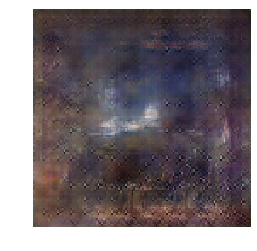

In [ ]:
random_vector_for_generation = tf.random_normal([1,1,1,
                                                 NOISE_DIM])
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
img = generator(random_vector_for_generation, training=False)
plt.imshow((img[0,:,:]+1)/2)
plt.axis('off')


Zip and download checkpoints

In [ ]:
!zip model_checkpoint_landscapes_100.zip '/content/training_checkpoints/checkpoint' '/content/training_checkpoints/ckpt-art-fit-abst_this-10.data-00000-of-00002' '/content/training_checkpoints/ckpt-art-fit-abst_this-10.data-00001-of-00002' '/content/training_checkpoints/ckpt-art-fit-abst_this-10.index'
#!zip -r landscape.zip /content/landscape
#!zip -r still_life.zip /content/still-life
!cp model_checkpoint_landscapes_100.zip '/content/drive/My Drive/model_checkpoint_landscapes_100.zip'
#!cp landscape.zip '/content/drive/My Drive/landscape.zip'
#!cp still_life.zip '/content/drive/My Drive/still_life.zip'
!ls '/content/drive/My Drive'

  adding: content/training_checkpoints/checkpoint (deflated 43%)
  adding: content/training_checkpoints/ckpt-art-fit-abst_this-10.data-00000-of-00002 (deflated 88%)
  adding: content/training_checkpoints/ckpt-art-fit-abst_this-10.data-00001-of-00002 (deflated 7%)
  adding: content/training_checkpoints/ckpt-art-fit-abst_this-10.index (deflated 75%)
 BA				       model_checkpoint_landscapes.zip
'Colab Notebooks'		       model_checkpoint.zip
 cs230exam_spr18_soln.pdf	       Mrgavet_PeachLiquor.jpg
'Deep learning.pdf'		       Nlp_Project
 F16sampleMidterm.pdf		       still_life.zip
 landscape.zip			       Stuff
 model_checkpoint_landscapes_100.zip   Theater
